In [519]:
import pandas as pd
import numpy as np
import sberPM as pm
from matplotlib import pyplot as plt

from sberPM.metrics import TimeMetric, ActivityMetric, UsersMetric, CycleMetric, LoadMetric
from sberPM.visual import GraphvizPainter
from sberPM.autoinsights import AutoInsights

from collections import Counter

import pymorphy2
from nltk.tokenize import word_tokenize

In [21]:
df = pd.read_csv('data/Полный датасет без пустых.csv', encoding='Windows-1251', sep=';', low_memory=False)

In [22]:
df.shape

(3775244, 20)


### Names after triggers using morphanalyzer

In [281]:
comments = np.unique(df['Комментарий создателя'].fillna('0'))
comments

array([' В связи Выводом созаемщика, Прошу выслать оригинал закладной для снятия обременения согласно ТС 2417-3 (изменения №9). Оригинал выслать в адрес: Москва, ул. Никулинская, д. 25, для Питера М.Ю., телефон 8(916) 604-46-57. В случае отсутствия закладной прикрепить сканы кредитного досье в ЭГО',
       ' В связи с внесением изменений (аннулирование). Оригинал закладной прошу выслать в адрес: 142200, МО, г.Серпухов, ул.Луначарского, д. 33а,каб.206, для Николаевой Ксении Николаевны, телефонраб 8(985) 383-61-97   лич 8(916) 344-09-28. В случае отсутствия закладной прикрепить сканы кредитного досье в ЭГО',
       ' В связи с выводом созаемщика Прошу выслать оригинал закладной для внесения изменений согласно ТС 2417 Оригинал выслать в адрес: Москва, ул. Никулинская, д. 25, для Питера М.Ю., телефон 8(916) 604-46-57. Скан образ разместить в ОАД||||173769/20|04|28.5.2020 13:46:00|44,99|40,22||||',
       ...,
       'штрих код 1426049947500171645348502182183054901904 штрих код 119812480963

In [75]:
morph = pymorphy2.MorphAnalyzer()

documents = [[morph.parse(word)[0].normal_form for word in word_tokenize(comment)] for comment in comments]

In [76]:
words = []

for d in documents:
    words += d
    
{k: v for k, v in sorted(Counter(words).items(), key=lambda item: -item[1])}

{',': 13068,
 '.': 10866,
 'в': 8308,
 'для': 5226,
 '(': 4817,
 ')': 4803,
 'закладная': 4664,
 'просить': 4412,
 'по': 3738,
 ':': 3718,
 'оригинал': 3452,
 'предоставить': 3313,
 'досье': 3222,
 'на': 2981,
 'скан': 2941,
 'с': 2705,
 'документ': 2692,
 'кредитный': 2613,
 'копия': 2332,
 'выслать': 2168,
 'связь': 2146,
 'адрес': 2146,
 'изменение': 1932,
 'согласно': 1929,
 'г.': 1891,
 'тс': 1684,
 'счёт': 1618,
 '8': 1610,
 'отсутствие': 1585,
 '2417-3': 1570,
 '!': 1569,
 'и': 1546,
 'случай': 1539,
 'прикрепить': 1464,
 'ул': 1458,
 'от': 1453,
 'клиент': 1447,
 'кредит': 1441,
 '№9': 1425,
 'снятие': 1379,
 'закрытие': 1342,
 'обременение': 1321,
 'договор': 1308,
 'запрос': 1294,
 'необходимый': 1226,
 'телефон': 1077,
 'день': 1033,
 'заявление': 996,
 'москва': 989,
 'просьба': 989,
 'добрый': 970,
 'первичный': 896,
 'весь': 829,
 'о': 771,
 'далее': 752,
 '№': 722,
 'спасибо': 642,
 'мо': 635,
 'томилино': 594,
 'алц': 594,
 'сумма': 594,
 'налоговый': 576,
 'заявка': 56

In [474]:
morph.parse('всего')[0].normal_form

'всего'

In [394]:
documents_word_only = [[word for word in doc if word.isalpha()] for doc in documents]

In [561]:
triggers_start = [
            'скан', 
            'выслать', 
            'предоставить', 
            'оригинал', 
            'прикрепить', 
            'приложить', 
            'перезагрузить',
            'копия', 
            'направить', 
            'выгрузить',
            '#',
            'необходимый',
            'сшив',
            'хватает', 
            'нужно',
            'подгрузить', 
            'предоставление',
            'разместить',
            'срочно',
            'загрузить',
            'требоваться',
#             'просить',
            'прогрузить', 
            'отсканировать', 
            'вложить', 
            'изготовить', 
            'отсутствовать', 
            'выдать', 
            'пересканировать', 
            'запрос', 
            'прислать',
#             'документ',
            'сделать', 
            'отправить', 
            'доставка', 
            'выдача', 
            'всего', 
            'весь']

triggers_end = ['для',
                'согласно', 
                'в', 
                'по', 
                'спасибо', 
                'на', 
                'вместо', 
                'с', 
                'от', 
                'из', 
                'за', 
                'тк', 
                'и', 
                'до',
                'о',
                'он', 
                'на', 
                'связь', 
                'от', 
                'так', 
                'добрый', 
                'день', 
                'уважаемый']

In [562]:
document_key_texts = []
documents_after_trigger = []
# document_main_text = []

for i, document in enumerate(documents_word_only):
    document_key_text = []
    after_trigger = []
    
    for trigger in triggers_start:
        
#         main_text_found = False
        
        if trigger in document:
            key_text = document[document.index(trigger)+1:]
            after_trigger = key_text
#             print(trigger, key_text)
            
            trig_end_found = False
            for trig_end in triggers_end:
                if trig_end in key_text:
                    key_text = key_text[:key_text.index(trig_end)]
                    trig_end_found = True
                    break
                    
            if not trig_end_found:      
                for trig_end in triggers_start:
                    if trig_end in key_text:
                        if key_text.index(trig_end) >= 2 and key_text.index(trig_end) <= 5:
                            key_text = key_text[:key_text.index(trig_end)]
                        trig_end_found = True
                        break
                
#             if not trig_end_found:
#                 print(key_text)
            key_text = key_text[:4]
            
            document_key_text += [word for word in key_text if word not in document_key_text+triggers_start+triggers_end]
            
#             if len(document_key_text) > 1:
#                 break
                
    if len(after_trigger) == 0:
        after_trigger = document
        
    if len(document_key_text) == 0:
        document_key_text = document[:4]
        
    if len(document_key_text) == 0:
        document_key_text = comments[i].split(' ')[:4]
        
    
    documents_after_trigger.append(after_trigger)        
    document_key_texts.append(document_key_text)
        
                
            
                    
                

In [563]:
document_key_texts

[['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'адрес', 'мо', 'далее', 'закладная', 'просить'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ',
  'закладная',
  'заказать',
  'полностью',
  'досье',
  'клиент',
  'запрашивать'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ',
  'закладная',
  'заказать',
  'полностью',
  'досье',
  'клиент',
  'запрашивать'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['образ', 'закладная', 'эго', 'документ', 'включить'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', 'закладная'],
 ['кредитный', 'досье', '

### clustering

In [441]:
from sberPM.ml.text import TextPreprocessing, TextClustering
from sberPM.ml.vectorizer import TextWord2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

In [440]:
# preprocessing = TextPreprocessing(2, 5)
# cleaned_texts = preprocessing.transform(comments)
# cleaned_texts

In [438]:
documents_after_trigger

[['оригинал',
  'закладная',
  'для',
  'снятие',
  'обременение',
  'согласно',
  'тс',
  'изменение',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'в',
  'случай',
  'отсутствие',
  'закладная',
  'прикрепить',
  'скан',
  'кредитный',
  'досье',
  'в',
  'эго'],
 ['в',
  'адрес',
  'мо',
  'далее',
  'для',
  'николаев',
  'ксения',
  'николай',
  'телефонраб',
  'лич',
  'в',
  'случай',
  'отсутствие',
  'закладная',
  'прикрепить',
  'скан',
  'кредитный',
  'досье',
  'в',
  'эго'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'центральный',
  'подчинение',
  'поддержка',
  'партнёр',
  'и',
  'ипотечный',
  'кредитование',
  'региональный',
  'центр',
  'отдел',
  'по',
  'сопровождение',
  'ипотека'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал',
  'выслать',
  'в',
  'адрес',
  'москва',
  'ул',
  'никулинский',
  'далее',
  'для',
  'питер',
  'телефон',
  'скан',
  'образ',
  'разместить',
  'в',
  'москва',
  'томилино',
  'алц'],
 ['оригинал',
  'закладная',
  'для',
  'внесение',
  'изменение',
  'согласно',
  'тс',
  'оригинал'

In [564]:
bow = CountVectorizer()
# text_embeddings = bow.fit_transform([' '.join(text) for text in documents_after_trigger])
text_embeddings = bow.fit_transform([' '.join(text) for text in document_key_texts])

In [536]:
models = {}
silhouette_scores = []
i = 0
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k,  random_state=1).fit(text_embeddings)
    score = silhouette_score(text_embeddings, kmeans.labels_)
    silhouette_scores.append(score)

    i += 1
    models[score] = kmeans
_model = models[max(models)]

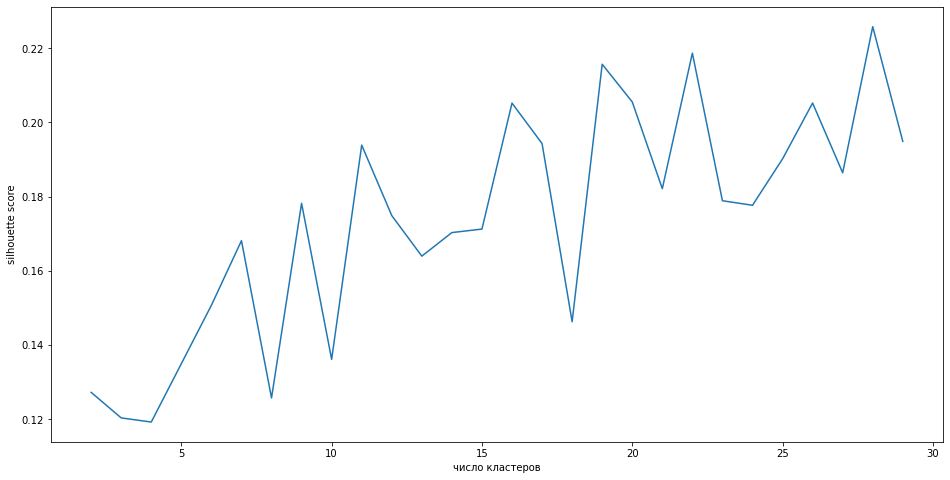

In [537]:
plt.figure(figsize=(16,8))
plt.xlabel('число кластеров')
plt.ylabel('silhouette score')
plt.plot(range(2, 30), list(models.keys()))
plt.show()

In [565]:
n_clusters = 16
_model = KMeans(n_clusters=n_clusters,  random_state=1).fit(text_embeddings)
labels = _model.predict(text_embeddings)

### cluster interpretation

In [568]:
clust2words = {}

for i in range(n_clusters):
    center = _model.cluster_centers_[i]
    top_inds = np.argsort(center)[::-1][:5]
    words = np.array(bow.get_feature_names())
    
#     print(i, '-', words[top_inds])
    
    clust2words[i] = ', '.join(words[top_inds])

In [569]:
# with key_text 16 clusters
clust2words

{0: '005, 210, 150, 190, 180',
 1: 'закладная, досье, кредитный, адрес, адресат',
 2: 'заявление, просить, клиент, упс, ува',
 3: 'заявка, для, на, завещание, счёт',
 4: 'просить, досье, предоставить, скан, crm',
 5: 'документ, пакет, наследственный, первичный, клиент',
 6: 'документация, кредитный, первичный, клиент, срм',
 7: 'досье, первичный, кредитный, для, документ',
 8: 'завещательный, распоряжение, подразделение, сбербанк, от',
 9: 'договор, кредитный, страхование, клиент, вклад',
 10: 'закладная, образ, адрес, заявка, дополнение',
 11: 'нотариальный, документ, заявление, вкл, вкладчик',
 12: 'ордер, расходный, мемориальный, кассовый, на',
 13: 'цзк, срм, обращение, задача, просить',
 14: 'клиент, досье, кредитный, полный, первичный',
 15: 'паспорт, клиент, цзк, технический, тот'}

In [535]:
# with key_text 11 clusters
clust2words

{0: 'ордер, расходный, мемориальный, документ, кассовый',
 1: 'заявление, на, заявка, цзк, рко',
 2: 'досье, первичный, клиент, кредитный, документ',
 3: 'договор, кредитный, страхование, клиент, вклад',
 4: 'документ, заявление, нотариальный, клиент, пакет',
 5: 'закладная, адрес, образ, досье, заявка',
 6: 'ува, ца, заявление, клиент, проверка',
 7: 'кредитный, досье, закладная, адрес, указанный',
 8: 'поручение, платёжный, перечисление, на, клиент',
 9: 'завещательный, распоряжение, подразделение, сбербанк, от',
 10: 'для, налоговый, документ, вычет, нв'}

In [525]:
# with after trigger text
clust2words

{0: 'для, досье, документ, по, кредитный, договор, скан, копия, первичный, на',
 1: 'закладная, для, оригинал, адрес, тс, согласно, изменение, скан, телефон, снятие',
 2: 'на, счёт, по, заявление, от, сумма, клиент, рубль, карта, копия',
 3: 'от, по, воронеж, адрес, оригинал, кд, документ, втс, лариса, александр',
 4: 'закладная, оригинал, отсутствие, скан, случай, прикрепить, досье, кредитный, эго, для',
 5: 'закладная, оригинал, по, адрес, для, ул, направить, просить, далее, согласно'}

### add to df

In [578]:
indices = [list(comments).index(comment) for comment in df['Комментарий создателя'].fillna('0')]

KeyboardInterrupt: 

In [ ]:
df['Название документа (Комментарий создателя)'] = [document_key_texts[ind] for ind in indices]
df['Номер кластера'] = [labels[ind] for ind in indices]
df['Ключевые слова кластера'] = [clust2words[cluster] for cluster in df['Номер кластера']]

In [ ]:
df.head()

In [581]:
clust2words

{0: '005, 210, 150, 190, 180',
 1: 'закладная, досье, кредитный, адрес, адресат',
 2: 'заявление, просить, клиент, упс, ува',
 3: 'заявка, для, на, завещание, счёт',
 4: 'просить, досье, предоставить, скан, crm',
 5: 'документ, пакет, наследственный, первичный, клиент',
 6: 'документация, кредитный, первичный, клиент, срм',
 7: 'досье, первичный, кредитный, для, документ',
 8: 'завещательный, распоряжение, подразделение, сбербанк, от',
 9: 'договор, кредитный, страхование, клиент, вклад',
 10: 'закладная, образ, адрес, заявка, дополнение',
 11: 'нотариальный, документ, заявление, вкл, вкладчик',
 12: 'ордер, расходный, мемориальный, кассовый, на',
 13: 'цзк, срм, обращение, задача, просить',
 14: 'клиент, досье, кредитный, полный, первичный',
 15: 'паспорт, клиент, цзк, технический, тот'}

In [582]:
labels[0]

1

In [583]:
comment_dict = {comment:{'doc_name':document_key_texts[i], 
                          'clust_num':labels[i], 
                          'clust_key_words':clust2words[labels[i]]} for i, comment in enumerate(comments)}



In [591]:
# comment_dict

In [599]:
pip install progress

  Created wheel for progress: filename=progress-1.5-py3-none-any.whl size=8074 sha256=0758a016a7fb9c33887c5eb4a6e3155baf24282eff27f5a68c7eb011a1bf2ede
  Stored in directory: /Users/aydar/Library/Caches/pip/wheels/4c/ff/85/0cabf2cb317421028ef98853ae5c8d84c31f3e4e11862ea977
Successfully built progress
Note: you may need to restart the kernel to use updated packages.


In [602]:
from progress.bar import IncrementalBar
import time

mylist = [1,2,3,4,5,6,7,8]

bar = IncrementalBar('Countdown', max = len(mylist))

for item in mylist:
    bar.next()
    time.sleep(1)

bar.finish()

In [608]:
for comment in comment_dict:
    comment_dict[comment]['doc_name'] = ' '.join(comment_dict[comment]['doc_name'])

In [609]:
x = 2000
x%1000

0

In [612]:
df.loc[df['Комментарий создателя'] == '']

Empty DataFrame
Columns: [ШК досье, № глобальной заявки, № внутренней заявки, Событие, Дата события, ТН исполнителя, Вид работ по заявке, Комментарий создателя, Комментарий при закрытии заявки, Площадка исполнителя, Номер реестра, Номер наряда, КБП, Плановая дата исполнения заявки, Тнорм, Тфакт, Level1, Level2, Level3, Level4, Название документа (Комментарий создателя), Номер кластера, Ключевые слова кластера]
Index: []

[0 rows x 23 columns]

In [615]:
for i, comment in enumerate(comments):
    if i%1000==0:
        print(i)
    key_name = comment_dict[comment]['doc_name']
    cluster = comment_dict[comment]['clust_num']
    cluster_words = comment_dict[comment]['clust_key_words']
    
    df.loc[df['Комментарий создателя'] == comment, 'Название документа (Комментарий создателя)'] = key_name
    df.loc[df['Комментарий создателя'] == comment, 'Номер кластера'] = cluster
    df.loc[df['Комментарий создателя'] == comment, 'Ключевые слова кластера'] = cluster_words

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [621]:
df.loc[12, 'Комментарий создателя']

'«В связи с закрытием кредита просим предоставить оригинал закладной для снятия обременения согласно технологической схеме 2417-3 (изменение №9) п.17.. Оригинал выслать в адрес ЦОППиИК: г. Нижний Новгород, ул. Гордеевская, д. 105, 4 этаж Токиной Е.А. 89601947591. В  случае отсутствия закладной прикрепить сканы кредитного досье в ЭГО»'

In [619]:
df.head(30)[['Комментарий создателя', 'Название документа (Комментарий создателя)']]

Комментарий создателя  \
0   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
1   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
2   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
3   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
4   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
5   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
6   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
7   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
8   ПЦП Урегулирование г.Воронеж Срок исполнения д...   
9   Необходимо прикрепить скан копии первичного до...   
10  Необходимо прикрепить скан копии первичного до...   
11  В связи с закрытием кредита просим предоставит...   
12  «В связи с закрытием кредита просим предостави...   
13  Добрый день! Просьба выгрузить первичную докум...   
14  Добрый день! Просьба выгрузить первичную докум...   
15  «В связи с закрытием кредита просим предостави...   
16                                                NaN   
17                                                NaN   
18  В связи с закрытием кредита просим предоставит...   
19  В связи с закрытием кредита просим предоставит...   
20  В связи с закрытием кредита просим предоставит...   
21  В связи с закрытием кредита просим предоставит...   
22                            выгружен уак мониторинг   
23                                                NaN   
24                          Заявление о присоединении   
25                          Заявление о присоединении   
26                        Задача СРМ №1-1259036140457   
27                        Задача СРМ №1-1259036140457   
28  В связи с закрытием кредита просим предоставит...   
29  Добрый день, необходимы документы о решении су...   

   Название документа (Комментарий создателя)  
0                  ранее единый файл неверный  
1                  ранее единый файл неверный  
2                  ранее единый файл неверный  
3                  ранее единый файл неверный  
4                  ранее единый файл неверный  
5                  ранее единый файл неверный  
6                  ранее единый файл неверный  
7                  ранее единый файл неверный  
8                  ранее единый файл неверный  
9                             первичный досье  
10                            первичный досье  
11  кредитный досье закладная ул куйбышев каб  
12                  кредитный досье закладная  
13              первичный документация заявка  
14              первичный документация заявка  
15                  кредитный досье закладная  
16                                          0  
17                                          0  
18                  кредитный досье закладная  
19                  кредитный досье закладная  
20                  кредитный досье закладная  
21                  кредитный досье закладная  
22                             уак мониторинг  
23                                          0  
24                  заявление о присоединение  
25                  заявление о присоединение  
26                                 задача срм  
27                                 задача срм  
28  кредитный досье закладная ул куйбышев каб  
29                       документ решение суд

In [617]:
df.to_csv('data/new_df.csv', index=False)

In [607]:

for i, row in enumerate(df.fillna('0')):
    if i%1000==0:
        print(i)
        
    comment = row['Комментарий создателя']
    
    key_name = comment_dict[comment]['doc_name']
    cluster = comment_dict[comment]['clust_num']
    cluster_words = comment_dict[comment]['clust_key_words']
    
    df.loc[i, 'Название документа (Комментарий создателя)'] = key_name
    df.loc[i, 'Номер кластера'] = cluster
    df.loc[i, 'Ключевые слова кластера'] = cluster_words
    
    
    





  0%|          | 0/3775244 [00:00<?, ?it/s]



  0%|          | 1/3775244 [00:00<302:07:35,  3.47it/s]



  0%|          | 2/3775244 [00:00<301:31:41,  3.48it/s]



  0%|          | 3/3775244 [00:00<300:51:16,  3.49it/s]



  0%|          | 4/3775244 [00:01<300:38:23,  3.49it/s]



  0%|          | 5/3775244 [00:01<303:58:14,  3.45it/s]



  0%|          | 6/3775244 [00:01<306:43:15,  3.42it/s]



  0%|          | 7/3775244 [00:02<308:22:27,  3.40it/s]



  0%|          | 8/3775244 [00:02<306:50:42,  3.42it/s]



  0%|          | 9/3775244 [00:02<305:59:08,  3.43it/s]



  0%|          | 10/3775244 [00:02<305:29:14,  3.43it/s]



  0%|          | 11/3775244 [00:03<304:28:29,  3.44it/s]



  0%|          | 12/3775244 [00:03<303:51:19,  3.45it/s]



  0%|          | 13/3775244 [00:03<303:33:27,  3.45it/s]



  0%|          | 14/3775244 [00:04<304:09:05,  3.45it/s]



  0%|          | 15/3775244 [00:04<304:28:38,  3.44it/s]



  0%|          | 16/3775244 [00:04<304:51:23,  3.44it/s]



  0%|          | 225/3775244 [01:04<295:22:03,  3.55it/s]



  0%|          | 226/3775244 [01:04<294:07:09,  3.57it/s]



  0%|          | 227/3775244 [01:04<293:32:02,  3.57it/s]



  0%|          | 228/3775244 [01:05<292:41:36,  3.58it/s]



  0%|          | 229/3775244 [01:05<292:20:28,  3.59it/s]



  0%|          | 230/3775244 [01:05<291:44:47,  3.59it/s]



  0%|          | 231/3775244 [01:05<291:22:21,  3.60it/s]



  0%|          | 232/3775244 [01:06<290:55:33,  3.60it/s]



  0%|          | 233/3775244 [01:06<291:06:34,  3.60it/s]



  0%|          | 234/3775244 [01:06<291:03:47,  3.60it/s]



  0%|          | 235/3775244 [01:06<291:35:30,  3.60it/s]



  0%|          | 236/3775244 [01:07<291:04:35,  3.60it/s]



  0%|          | 237/3775244 [01:07<290:46:56,  3.61it/s]



  0%|          | 238/3775244 [01:07<290:18:59,  3.61it/s]



  0%|          | 239/3775244 [01:08<290:21:28,  3.61it/s]



  0%|          | 240/3775244 [01:08<290:31:28,  3.61it/s]



  0%|          | 241/377

  0%|          | 449/3775244 [02:06<291:40:29,  3.59it/s]



  0%|          | 450/3775244 [02:06<291:35:16,  3.60it/s]



  0%|          | 451/3775244 [02:07<293:34:55,  3.57it/s]



  0%|          | 452/3775244 [02:07<293:02:16,  3.58it/s]



  0%|          | 453/3775244 [02:07<292:29:11,  3.58it/s]



  0%|          | 454/3775244 [02:07<292:23:18,  3.59it/s]



  0%|          | 455/3775244 [02:08<292:03:50,  3.59it/s]



  0%|          | 456/3775244 [02:08<292:00:00,  3.59it/s]



  0%|          | 457/3775244 [02:08<292:25:01,  3.59it/s]



  0%|          | 458/3775244 [02:09<294:02:33,  3.57it/s]



  0%|          | 459/3775244 [02:09<294:36:33,  3.56it/s]



  0%|          | 460/3775244 [02:09<293:42:06,  3.57it/s]



  0%|          | 461/3775244 [02:09<294:09:59,  3.56it/s]



  0%|          | 462/3775244 [02:10<292:49:59,  3.58it/s]



  0%|          | 463/3775244 [02:10<292:24:41,  3.59it/s]



  0%|          | 464/3775244 [02:10<291:51:34,  3.59it/s]



  0%|          | 465/377

  0%|          | 673/3775244 [03:08<291:23:27,  3.60it/s]



  0%|          | 674/3775244 [03:09<292:12:05,  3.59it/s]



  0%|          | 675/3775244 [03:09<292:40:38,  3.58it/s]



  0%|          | 676/3775244 [03:09<292:14:12,  3.59it/s]



  0%|          | 677/3775244 [03:10<291:41:38,  3.59it/s]



  0%|          | 678/3775244 [03:10<292:36:27,  3.58it/s]



  0%|          | 679/3775244 [03:10<291:59:10,  3.59it/s]



  0%|          | 680/3775244 [03:10<291:35:53,  3.60it/s]



  0%|          | 681/3775244 [03:11<291:20:26,  3.60it/s]



  0%|          | 682/3775244 [03:11<291:16:00,  3.60it/s]



  0%|          | 683/3775244 [03:11<291:38:17,  3.60it/s]



  0%|          | 684/3775244 [03:12<292:01:34,  3.59it/s]



  0%|          | 685/3775244 [03:12<291:31:38,  3.60it/s]



  0%|          | 686/3775244 [03:12<291:15:49,  3.60it/s]



  0%|          | 687/3775244 [03:12<291:10:41,  3.60it/s]



  0%|          | 688/3775244 [03:13<292:12:08,  3.59it/s]



  0%|          | 689/377

  0%|          | 897/3775244 [04:11<291:38:02,  3.60it/s]



  0%|          | 898/3775244 [04:11<292:16:51,  3.59it/s]



  0%|          | 899/3775244 [04:11<292:13:26,  3.59it/s]



  0%|          | 900/3775244 [04:12<293:49:41,  3.57it/s]



  0%|          | 901/3775244 [04:12<293:04:23,  3.58it/s]



  0%|          | 902/3775244 [04:12<292:08:03,  3.59it/s]



  0%|          | 903/3775244 [04:13<292:31:32,  3.58it/s]



  0%|          | 904/3775244 [04:13<292:00:13,  3.59it/s]



  0%|          | 905/3775244 [04:13<291:40:29,  3.59it/s]



  0%|          | 906/3775244 [04:13<292:06:04,  3.59it/s]



  0%|          | 907/3775244 [04:14<291:55:10,  3.59it/s]



  0%|          | 908/3775244 [04:14<292:16:43,  3.59it/s]



  0%|          | 909/3775244 [04:14<291:37:19,  3.60it/s]



  0%|          | 910/3775244 [04:15<291:04:43,  3.60it/s]



  0%|          | 911/3775244 [04:15<291:12:35,  3.60it/s]



  0%|          | 912/3775244 [04:15<291:08:27,  3.60it/s]



  0%|          | 913/377

  0%|          | 1119/3775244 [05:13<293:33:14,  3.57it/s]



  0%|          | 1120/3775244 [05:13<293:16:01,  3.57it/s]



  0%|          | 1121/3775244 [05:13<296:39:57,  3.53it/s]



  0%|          | 1122/3775244 [05:14<295:11:40,  3.55it/s]



  0%|          | 1123/3775244 [05:14<293:03:08,  3.58it/s]



  0%|          | 1124/3775244 [05:14<292:25:42,  3.59it/s]



  0%|          | 1125/3775244 [05:15<293:01:13,  3.58it/s]



  0%|          | 1126/3775244 [05:15<292:53:18,  3.58it/s]



  0%|          | 1127/3775244 [05:15<292:21:25,  3.59it/s]



  0%|          | 1128/3775244 [05:15<292:01:31,  3.59it/s]



  0%|          | 1129/3775244 [05:16<292:18:35,  3.59it/s]



  0%|          | 1130/3775244 [05:16<290:42:06,  3.61it/s]



  0%|          | 1131/3775244 [05:16<289:58:26,  3.62it/s]



  0%|          | 1132/3775244 [05:17<290:57:52,  3.60it/s]



  0%|          | 1133/3775244 [05:17<293:14:26,  3.58it/s]



  0%|          | 1134/3775244 [05:17<292:47:37,  3.58it/s]



  0%|   

  0%|          | 1339/3775244 [06:14<284:42:00,  3.68it/s]



  0%|          | 1340/3775244 [06:14<284:07:47,  3.69it/s]



  0%|          | 1341/3775244 [06:14<284:22:57,  3.69it/s]



  0%|          | 1342/3775244 [06:14<285:41:17,  3.67it/s]



  0%|          | 1343/3775244 [06:15<284:13:29,  3.69it/s]



  0%|          | 1344/3775244 [06:15<283:05:08,  3.70it/s]



  0%|          | 1345/3775244 [06:15<282:25:38,  3.71it/s]



  0%|          | 1346/3775244 [06:16<285:37:34,  3.67it/s]



  0%|          | 1347/3775244 [06:16<287:35:56,  3.65it/s]



  0%|          | 1348/3775244 [06:16<288:27:09,  3.63it/s]



  0%|          | 1349/3775244 [06:16<285:42:02,  3.67it/s]



  0%|          | 1350/3775244 [06:17<285:42:43,  3.67it/s]



  0%|          | 1351/3775244 [06:17<288:15:05,  3.64it/s]



  0%|          | 1352/3775244 [06:17<287:13:23,  3.65it/s]



  0%|          | 1353/3775244 [06:17<285:53:27,  3.67it/s]



  0%|          | 1354/3775244 [06:18<289:34:34,  3.62it/s]



  0%|   

  0%|          | 1559/3775244 [07:14<293:56:09,  3.57it/s]



  0%|          | 1560/3775244 [07:14<294:37:17,  3.56it/s]



  0%|          | 1561/3775244 [07:15<294:27:04,  3.56it/s]



  0%|          | 1562/3775244 [07:15<293:47:44,  3.57it/s]



  0%|          | 1563/3775244 [07:15<294:37:00,  3.56it/s]



  0%|          | 1564/3775244 [07:16<293:45:59,  3.57it/s]



  0%|          | 1565/3775244 [07:16<293:15:00,  3.57it/s]



  0%|          | 1566/3775244 [07:16<293:38:15,  3.57it/s]



  0%|          | 1567/3775244 [07:16<293:37:18,  3.57it/s]



  0%|          | 1568/3775244 [07:17<292:52:42,  3.58it/s]



  0%|          | 1569/3775244 [07:17<293:01:37,  3.58it/s]



  0%|          | 1570/3775244 [07:17<292:18:00,  3.59it/s]



  0%|          | 1571/3775244 [07:18<296:46:02,  3.53it/s]



  0%|          | 1572/3775244 [07:18<294:58:37,  3.55it/s]



  0%|          | 1573/3775244 [07:18<293:50:54,  3.57it/s]



  0%|          | 1574/3775244 [07:18<295:10:18,  3.55it/s]



  0%|   

  0%|          | 1779/3775244 [08:16<291:58:14,  3.59it/s]



  0%|          | 1780/3775244 [08:16<291:50:23,  3.59it/s]



  0%|          | 1781/3775244 [08:16<293:35:37,  3.57it/s]



  0%|          | 1782/3775244 [08:16<293:47:40,  3.57it/s]



  0%|          | 1783/3775244 [08:17<293:56:08,  3.57it/s]



  0%|          | 1784/3775244 [08:17<293:01:17,  3.58it/s]



  0%|          | 1785/3775244 [08:17<292:30:19,  3.58it/s]



  0%|          | 1786/3775244 [08:18<300:02:07,  3.49it/s]



  0%|          | 1787/3775244 [08:18<297:00:54,  3.53it/s]



  0%|          | 1788/3775244 [08:18<295:15:51,  3.55it/s]



  0%|          | 1789/3775244 [08:18<294:55:41,  3.55it/s]



  0%|          | 1790/3775244 [08:19<294:18:51,  3.56it/s]



  0%|          | 1791/3775244 [08:19<293:25:55,  3.57it/s]



  0%|          | 1792/3775244 [08:19<292:36:37,  3.58it/s]



  0%|          | 1793/3775244 [08:20<293:41:19,  3.57it/s]



  0%|          | 1794/3775244 [08:20<293:10:13,  3.58it/s]



  0%|   

  0%|          | 1999/3775244 [09:17<292:37:25,  3.58it/s]



  0%|          | 2000/3775244 [09:17<297:31:20,  3.52it/s]



  0%|          | 2001/3775244 [09:18<296:27:17,  3.54it/s]



  0%|          | 2002/3775244 [09:18<294:54:54,  3.55it/s]



  0%|          | 2003/3775244 [09:18<293:53:27,  3.57it/s]



  0%|          | 2004/3775244 [09:19<293:32:09,  3.57it/s]



  0%|          | 2005/3775244 [09:19<292:54:06,  3.58it/s]



  0%|          | 2006/3775244 [09:19<292:13:44,  3.59it/s]



  0%|          | 2007/3775244 [09:19<291:56:23,  3.59it/s]



  0%|          | 2008/3775244 [09:20<293:30:58,  3.57it/s]



  0%|          | 2009/3775244 [09:20<293:14:20,  3.57it/s]



  0%|          | 2010/3775244 [09:20<293:30:12,  3.57it/s]



  0%|          | 2011/3775244 [09:21<295:48:17,  3.54it/s]



  0%|          | 2012/3775244 [09:21<298:01:13,  3.52it/s]



  0%|          | 2013/3775244 [09:21<297:11:27,  3.53it/s]



  0%|          | 2014/3775244 [09:21<296:07:50,  3.54it/s]



  0%|   

  0%|          | 2219/3775244 [10:19<292:47:37,  3.58it/s]



  0%|          | 2220/3775244 [10:19<292:28:03,  3.58it/s]



  0%|          | 2221/3775244 [10:19<293:07:12,  3.58it/s]



  0%|          | 2222/3775244 [10:20<292:41:01,  3.58it/s]



  0%|          | 2223/3775244 [10:20<293:40:15,  3.57it/s]



  0%|          | 2224/3775244 [10:20<293:12:00,  3.57it/s]



  0%|          | 2225/3775244 [10:20<292:54:08,  3.58it/s]



  0%|          | 2226/3775244 [10:21<292:24:02,  3.58it/s]



  0%|          | 2227/3775244 [10:21<292:10:17,  3.59it/s]



  0%|          | 2228/3775244 [10:21<291:52:05,  3.59it/s]



  0%|          | 2229/3775244 [10:22<291:38:26,  3.59it/s]



  0%|          | 2230/3775244 [10:22<292:22:32,  3.58it/s]



  0%|          | 2231/3775244 [10:22<292:08:52,  3.59it/s]



  0%|          | 2232/3775244 [10:22<293:33:36,  3.57it/s]



  0%|          | 2233/3775244 [10:23<292:53:18,  3.58it/s]



  0%|          | 2234/3775244 [10:23<293:36:21,  3.57it/s]



  0%|   

  0%|          | 2439/3775244 [11:20<291:22:43,  3.60it/s]



  0%|          | 2440/3775244 [11:20<294:03:33,  3.56it/s]



  0%|          | 2441/3775244 [11:21<294:42:21,  3.56it/s]



  0%|          | 2442/3775244 [11:21<295:00:39,  3.55it/s]



  0%|          | 2443/3775244 [11:21<294:26:41,  3.56it/s]



  0%|          | 2444/3775244 [11:22<295:38:40,  3.54it/s]



  0%|          | 2445/3775244 [11:22<297:55:23,  3.52it/s]



  0%|          | 2446/3775244 [11:22<296:30:59,  3.53it/s]



  0%|          | 2447/3775244 [11:22<295:33:30,  3.55it/s]



  0%|          | 2448/3775244 [11:23<297:38:33,  3.52it/s]



  0%|          | 2449/3775244 [11:23<296:27:04,  3.54it/s]



  0%|          | 2450/3775244 [11:23<295:29:36,  3.55it/s]



  0%|          | 2451/3775244 [11:24<294:59:24,  3.55it/s]



  0%|          | 2452/3775244 [11:24<294:03:51,  3.56it/s]



  0%|          | 2453/3775244 [11:24<292:54:00,  3.58it/s]



  0%|          | 2454/3775244 [11:24<295:10:06,  3.55it/s]



  0%|   

  0%|          | 2659/3775244 [12:22<293:50:26,  3.57it/s]



  0%|          | 2660/3775244 [12:22<294:14:51,  3.56it/s]



  0%|          | 2661/3775244 [12:22<294:27:26,  3.56it/s]



  0%|          | 2662/3775244 [12:23<293:54:30,  3.57it/s]



  0%|          | 2663/3775244 [12:23<293:38:37,  3.57it/s]



  0%|          | 2664/3775244 [12:23<293:34:23,  3.57it/s]



  0%|          | 2665/3775244 [12:23<293:53:36,  3.57it/s]



  0%|          | 2666/3775244 [12:24<294:16:37,  3.56it/s]



  0%|          | 2667/3775244 [12:24<293:59:07,  3.56it/s]



  0%|          | 2668/3775244 [12:24<294:14:37,  3.56it/s]



  0%|          | 2669/3775244 [12:25<292:51:51,  3.58it/s]



  0%|          | 2670/3775244 [12:25<292:20:37,  3.58it/s]



  0%|          | 2671/3775244 [12:25<293:32:54,  3.57it/s]



  0%|          | 2672/3775244 [12:25<292:57:40,  3.58it/s]



  0%|          | 2673/3775244 [12:26<292:48:34,  3.58it/s]



  0%|          | 2674/3775244 [12:26<293:37:48,  3.57it/s]



  0%|   

  0%|          | 2879/3775244 [13:23<294:59:50,  3.55it/s]



  0%|          | 2880/3775244 [13:24<293:50:22,  3.57it/s]



  0%|          | 2881/3775244 [13:24<293:26:02,  3.57it/s]



  0%|          | 2882/3775244 [13:24<294:39:36,  3.56it/s]



  0%|          | 2883/3775244 [13:24<293:47:57,  3.57it/s]



  0%|          | 2884/3775244 [13:25<295:03:07,  3.55it/s]



  0%|          | 2885/3775244 [13:25<295:39:05,  3.54it/s]



  0%|          | 2886/3775244 [13:25<294:43:30,  3.56it/s]



  0%|          | 2887/3775244 [13:26<293:44:07,  3.57it/s]



  0%|          | 2888/3775244 [13:26<293:52:16,  3.57it/s]



  0%|          | 2889/3775244 [13:26<294:44:21,  3.56it/s]



  0%|          | 2890/3775244 [13:26<293:51:14,  3.57it/s]



  0%|          | 2891/3775244 [13:27<293:25:32,  3.57it/s]



  0%|          | 2892/3775244 [13:27<292:56:13,  3.58it/s]



  0%|          | 2893/3775244 [13:27<292:38:41,  3.58it/s]



  0%|          | 2894/3775244 [13:27<293:11:42,  3.57it/s]



  0%|   

  0%|          | 3099/3775244 [14:25<292:48:10,  3.58it/s]



  0%|          | 3100/3775244 [14:25<292:37:30,  3.58it/s]



  0%|          | 3101/3775244 [14:25<292:30:54,  3.58it/s]



  0%|          | 3102/3775244 [14:26<292:35:56,  3.58it/s]



  0%|          | 3103/3775244 [14:26<292:34:07,  3.58it/s]



  0%|          | 3104/3775244 [14:26<292:08:56,  3.59it/s]



  0%|          | 3105/3775244 [14:26<291:40:24,  3.59it/s]



  0%|          | 3106/3775244 [14:27<292:08:42,  3.59it/s]



  0%|          | 3107/3775244 [14:27<292:05:20,  3.59it/s]



  0%|          | 3108/3775244 [14:27<291:58:11,  3.59it/s]



  0%|          | 3109/3775244 [14:28<292:57:33,  3.58it/s]



  0%|          | 3110/3775244 [14:28<293:42:23,  3.57it/s]



  0%|          | 3111/3775244 [14:28<292:58:07,  3.58it/s]



  0%|          | 3112/3775244 [14:28<292:28:10,  3.58it/s]



  0%|          | 3113/3775244 [14:29<293:49:12,  3.57it/s]



  0%|          | 3114/3775244 [14:29<293:12:13,  3.57it/s]



  0%|   

  0%|          | 3319/3775244 [15:27<291:32:39,  3.59it/s]



  0%|          | 3320/3775244 [15:27<292:58:34,  3.58it/s]



  0%|          | 3321/3775244 [15:27<293:20:05,  3.57it/s]



  0%|          | 3322/3775244 [15:28<292:56:28,  3.58it/s]



  0%|          | 3323/3775244 [15:28<292:38:14,  3.58it/s]



  0%|          | 3324/3775244 [15:28<294:13:26,  3.56it/s]



  0%|          | 3325/3775244 [15:29<293:47:28,  3.57it/s]



  0%|          | 3326/3775244 [15:29<293:26:51,  3.57it/s]



  0%|          | 3327/3775244 [15:29<293:19:49,  3.57it/s]



  0%|          | 3328/3775244 [15:29<292:52:32,  3.58it/s]



  0%|          | 3329/3775244 [15:30<292:17:39,  3.58it/s]



  0%|          | 3330/3775244 [15:30<292:29:45,  3.58it/s]



  0%|          | 3331/3775244 [15:30<293:06:03,  3.57it/s]



  0%|          | 3332/3775244 [15:30<292:27:38,  3.58it/s]



  0%|          | 3333/3775244 [15:31<292:19:11,  3.58it/s]



  0%|          | 3334/3775244 [15:31<291:59:06,  3.59it/s]



  0%|   

  0%|          | 3539/3775244 [16:28<292:20:26,  3.58it/s]



  0%|          | 3540/3775244 [16:28<292:39:26,  3.58it/s]



  0%|          | 3541/3775244 [16:29<293:29:12,  3.57it/s]



  0%|          | 3542/3775244 [16:29<292:40:57,  3.58it/s]



  0%|          | 3543/3775244 [16:29<292:10:51,  3.59it/s]



  0%|          | 3544/3775244 [16:30<291:43:38,  3.59it/s]



  0%|          | 3545/3775244 [16:30<291:35:14,  3.59it/s]



  0%|          | 3546/3775244 [16:30<291:20:30,  3.60it/s]



  0%|          | 3547/3775244 [16:30<291:46:36,  3.59it/s]



  0%|          | 3548/3775244 [16:31<292:22:09,  3.58it/s]



  0%|          | 3549/3775244 [16:31<292:01:10,  3.59it/s]



  0%|          | 3550/3775244 [16:31<291:57:07,  3.59it/s]



  0%|          | 3551/3775244 [16:32<292:10:39,  3.59it/s]



  0%|          | 3552/3775244 [16:32<293:21:33,  3.57it/s]



  0%|          | 3553/3775244 [16:32<293:02:57,  3.58it/s]



  0%|          | 3554/3775244 [16:32<292:14:55,  3.58it/s]



  0%|   

  0%|          | 3759/3775244 [17:30<292:28:38,  3.58it/s]



  0%|          | 3760/3775244 [17:30<292:49:55,  3.58it/s]



  0%|          | 3761/3775244 [17:30<293:07:24,  3.57it/s]



  0%|          | 3762/3775244 [17:31<292:09:15,  3.59it/s]



  0%|          | 3763/3775244 [17:31<291:44:09,  3.59it/s]



  0%|          | 3764/3775244 [17:31<292:16:27,  3.58it/s]



  0%|          | 3765/3775244 [17:31<291:58:37,  3.59it/s]



  0%|          | 3766/3775244 [17:32<291:32:47,  3.59it/s]



  0%|          | 3767/3775244 [17:32<291:55:35,  3.59it/s]



  0%|          | 3768/3775244 [17:32<292:11:47,  3.59it/s]



  0%|          | 3769/3775244 [17:32<291:52:40,  3.59it/s]



  0%|          | 3770/3775244 [17:33<291:22:17,  3.60it/s]



  0%|          | 3771/3775244 [17:33<291:22:05,  3.60it/s]



  0%|          | 3772/3775244 [17:33<291:13:27,  3.60it/s]



  0%|          | 3773/3775244 [17:34<291:11:11,  3.60it/s]



  0%|          | 3774/3775244 [17:34<291:23:44,  3.60it/s]



  0%|   

  0%|          | 3979/3775244 [18:31<292:12:07,  3.59it/s]



  0%|          | 3980/3775244 [18:31<291:54:02,  3.59it/s]



  0%|          | 3981/3775244 [18:32<291:31:47,  3.59it/s]



  0%|          | 3982/3775244 [18:32<291:22:01,  3.60it/s]



  0%|          | 3983/3775244 [18:32<292:21:59,  3.58it/s]



  0%|          | 3984/3775244 [18:32<292:23:33,  3.58it/s]



  0%|          | 3985/3775244 [18:33<292:32:21,  3.58it/s]



  0%|          | 3986/3775244 [18:33<293:44:43,  3.57it/s]



  0%|          | 3987/3775244 [18:33<294:39:33,  3.56it/s]



  0%|          | 3988/3775244 [18:34<293:35:24,  3.57it/s]



  0%|          | 3989/3775244 [18:34<293:28:26,  3.57it/s]



  0%|          | 3990/3775244 [18:34<293:39:40,  3.57it/s]



  0%|          | 3991/3775244 [18:34<293:06:30,  3.57it/s]



  0%|          | 3992/3775244 [18:35<292:45:42,  3.58it/s]



  0%|          | 3993/3775244 [18:35<292:59:39,  3.58it/s]



  0%|          | 3994/3775244 [18:35<292:23:10,  3.58it/s]



  0%|   

  0%|          | 4199/3775244 [19:33<291:32:36,  3.59it/s]



  0%|          | 4200/3775244 [19:33<291:57:37,  3.59it/s]



  0%|          | 4201/3775244 [19:33<291:44:56,  3.59it/s]



  0%|          | 4202/3775244 [19:33<291:11:53,  3.60it/s]



  0%|          | 4203/3775244 [19:34<291:22:49,  3.59it/s]



  0%|          | 4204/3775244 [19:34<292:04:45,  3.59it/s]



  0%|          | 4205/3775244 [19:34<292:44:04,  3.58it/s]



  0%|          | 4206/3775244 [19:34<292:23:29,  3.58it/s]



  0%|          | 4207/3775244 [19:35<292:18:12,  3.58it/s]



  0%|          | 4208/3775244 [19:35<292:35:17,  3.58it/s]



  0%|          | 4209/3775244 [19:35<292:48:11,  3.58it/s]



  0%|          | 4210/3775244 [19:36<292:19:38,  3.58it/s]



  0%|          | 4211/3775244 [19:36<291:57:05,  3.59it/s]



  0%|          | 4212/3775244 [19:36<292:02:35,  3.59it/s]



  0%|          | 4213/3775244 [19:36<291:27:20,  3.59it/s]



  0%|          | 4214/3775244 [19:37<291:06:59,  3.60it/s]



  0%|   

  0%|          | 4419/3775244 [20:34<291:55:38,  3.59it/s]



  0%|          | 4420/3775244 [20:34<292:43:39,  3.58it/s]



  0%|          | 4421/3775244 [20:35<293:12:15,  3.57it/s]



  0%|          | 4422/3775244 [20:35<292:43:20,  3.58it/s]



  0%|          | 4423/3775244 [20:35<292:35:30,  3.58it/s]



  0%|          | 4424/3775244 [20:35<292:54:50,  3.58it/s]



  0%|          | 4425/3775244 [20:36<292:26:17,  3.58it/s]



  0%|          | 4426/3775244 [20:36<292:50:51,  3.58it/s]



  0%|          | 4427/3775244 [20:36<292:08:53,  3.59it/s]



  0%|          | 4428/3775244 [20:36<291:56:55,  3.59it/s]



  0%|          | 4429/3775244 [20:37<292:19:32,  3.58it/s]



  0%|          | 4430/3775244 [20:37<292:27:02,  3.58it/s]



  0%|          | 4431/3775244 [20:37<292:34:34,  3.58it/s]



  0%|          | 4432/3775244 [20:38<292:14:32,  3.58it/s]



  0%|          | 4433/3775244 [20:38<292:05:28,  3.59it/s]



  0%|          | 4434/3775244 [20:38<291:53:36,  3.59it/s]



  0%|   

  0%|          | 4639/3775244 [21:35<292:05:08,  3.59it/s]



  0%|          | 4640/3775244 [21:36<292:46:07,  3.58it/s]



  0%|          | 4641/3775244 [21:36<293:16:24,  3.57it/s]



  0%|          | 4642/3775244 [21:36<293:03:12,  3.57it/s]



  0%|          | 4643/3775244 [21:36<294:11:20,  3.56it/s]



  0%|          | 4644/3775244 [21:37<293:01:39,  3.57it/s]



  0%|          | 4645/3775244 [21:37<292:31:40,  3.58it/s]



  0%|          | 4646/3775244 [21:37<292:21:36,  3.58it/s]



  0%|          | 4647/3775244 [21:38<292:56:58,  3.58it/s]



  0%|          | 4648/3775244 [21:38<292:06:41,  3.59it/s]



  0%|          | 4649/3775244 [21:38<292:12:35,  3.58it/s]



  0%|          | 4650/3775244 [21:38<292:56:31,  3.58it/s]



  0%|          | 4651/3775244 [21:39<294:07:29,  3.56it/s]



  0%|          | 4652/3775244 [21:39<293:05:04,  3.57it/s]



  0%|          | 4653/3775244 [21:39<292:38:20,  3.58it/s]



  0%|          | 4654/3775244 [21:40<292:05:01,  3.59it/s]



  0%|   

  0%|          | 4859/3775244 [22:37<291:45:46,  3.59it/s]



  0%|          | 4860/3775244 [22:37<292:20:49,  3.58it/s]



  0%|          | 4861/3775244 [22:37<292:42:04,  3.58it/s]



  0%|          | 4862/3775244 [22:38<292:27:02,  3.58it/s]



  0%|          | 4863/3775244 [22:38<291:51:07,  3.59it/s]



  0%|          | 4864/3775244 [22:38<292:10:16,  3.58it/s]



  0%|          | 4865/3775244 [22:38<293:36:01,  3.57it/s]



  0%|          | 4866/3775244 [22:39<292:48:44,  3.58it/s]



  0%|          | 4867/3775244 [22:39<292:23:43,  3.58it/s]



  0%|          | 4868/3775244 [22:39<293:13:43,  3.57it/s]



  0%|          | 4869/3775244 [22:40<292:30:35,  3.58it/s]



  0%|          | 4870/3775244 [22:40<292:12:56,  3.58it/s]



  0%|          | 4871/3775244 [22:40<291:47:35,  3.59it/s]



  0%|          | 4872/3775244 [22:40<292:12:54,  3.58it/s]



  0%|          | 4873/3775244 [22:41<292:37:04,  3.58it/s]



  0%|          | 4874/3775244 [22:41<292:03:28,  3.59it/s]



  0%|   

  0%|          | 5079/3775244 [23:38<292:31:06,  3.58it/s]



  0%|          | 5080/3775244 [23:39<293:45:42,  3.57it/s]



  0%|          | 5081/3775244 [23:39<293:41:09,  3.57it/s]



  0%|          | 5082/3775244 [23:39<292:50:10,  3.58it/s]



  0%|          | 5083/3775244 [23:39<292:00:14,  3.59it/s]



  0%|          | 5084/3775244 [23:40<291:26:56,  3.59it/s]



  0%|          | 5085/3775244 [23:40<292:47:02,  3.58it/s]



  0%|          | 5086/3775244 [23:40<291:59:47,  3.59it/s]



  0%|          | 5087/3775244 [23:40<293:28:18,  3.57it/s]



  0%|          | 5088/3775244 [23:41<292:34:40,  3.58it/s]



  0%|          | 5089/3775244 [23:41<294:20:35,  3.56it/s]



  0%|          | 5090/3775244 [23:41<293:23:14,  3.57it/s]



  0%|          | 5091/3775244 [23:42<292:25:19,  3.58it/s]



  0%|          | 5092/3775244 [23:42<291:50:38,  3.59it/s]



  0%|          | 5093/3775244 [23:42<292:20:02,  3.58it/s]



  0%|          | 5094/3775244 [23:42<291:47:05,  3.59it/s]



  0%|   

  0%|          | 5299/3775244 [24:40<291:06:39,  3.60it/s]



  0%|          | 5300/3775244 [24:40<291:54:15,  3.59it/s]



  0%|          | 5301/3775244 [24:40<292:02:24,  3.59it/s]



  0%|          | 5302/3775244 [24:40<291:26:15,  3.59it/s]



  0%|          | 5303/3775244 [24:41<292:20:57,  3.58it/s]



  0%|          | 5304/3775244 [24:41<291:48:57,  3.59it/s]



  0%|          | 5305/3775244 [24:41<292:11:46,  3.58it/s]



  0%|          | 5306/3775244 [24:42<291:46:11,  3.59it/s]



  0%|          | 5307/3775244 [24:42<291:56:16,  3.59it/s]



  0%|          | 5308/3775244 [24:42<292:19:29,  3.58it/s]



  0%|          | 5309/3775244 [24:42<292:11:32,  3.58it/s]



  0%|          | 5310/3775244 [24:43<291:54:49,  3.59it/s]



  0%|          | 5311/3775244 [24:43<291:40:33,  3.59it/s]



  0%|          | 5312/3775244 [24:43<291:10:11,  3.60it/s]



  0%|          | 5313/3775244 [24:44<291:08:34,  3.60it/s]



  0%|          | 5314/3775244 [24:44<291:54:34,  3.59it/s]



  0%|   

  0%|          | 5519/3775244 [25:41<292:06:59,  3.58it/s]



  0%|          | 5520/3775244 [25:41<293:30:27,  3.57it/s]



  0%|          | 5521/3775244 [25:42<293:22:50,  3.57it/s]



  0%|          | 5522/3775244 [25:42<292:24:02,  3.58it/s]



  0%|          | 5523/3775244 [25:42<292:34:24,  3.58it/s]



  0%|          | 5524/3775244 [25:42<292:34:03,  3.58it/s]



  0%|          | 5525/3775244 [25:43<291:58:56,  3.59it/s]



  0%|          | 5526/3775244 [25:43<292:37:02,  3.58it/s]



  0%|          | 5527/3775244 [25:43<292:39:29,  3.58it/s]



  0%|          | 5528/3775244 [25:44<292:06:56,  3.58it/s]



  0%|          | 5529/3775244 [25:44<292:36:43,  3.58it/s]



  0%|          | 5530/3775244 [25:44<291:49:37,  3.59it/s]



  0%|          | 5531/3775244 [25:44<291:22:34,  3.59it/s]



  0%|          | 5532/3775244 [25:45<291:12:43,  3.60it/s]



  0%|          | 5533/3775244 [25:45<290:52:43,  3.60it/s]



  0%|          | 5534/3775244 [25:45<291:26:10,  3.59it/s]



  0%|   

  0%|          | 5739/3775244 [26:42<292:58:01,  3.57it/s]



  0%|          | 5740/3775244 [26:43<292:53:42,  3.57it/s]



  0%|          | 5741/3775244 [26:43<292:26:37,  3.58it/s]



  0%|          | 5742/3775244 [26:43<291:47:57,  3.59it/s]



  0%|          | 5743/3775244 [26:43<291:24:55,  3.59it/s]



  0%|          | 5744/3775244 [26:44<291:32:24,  3.59it/s]



  0%|          | 5745/3775244 [26:44<292:19:23,  3.58it/s]



  0%|          | 5746/3775244 [26:44<292:03:11,  3.59it/s]



  0%|          | 5747/3775244 [26:45<292:14:57,  3.58it/s]



  0%|          | 5748/3775244 [26:45<292:54:47,  3.57it/s]



  0%|          | 5749/3775244 [26:45<292:58:07,  3.57it/s]



  0%|          | 5750/3775244 [26:45<293:55:54,  3.56it/s]



  0%|          | 5751/3775244 [26:46<294:10:07,  3.56it/s]



  0%|          | 5752/3775244 [26:46<293:20:17,  3.57it/s]



  0%|          | 5753/3775244 [26:46<292:42:30,  3.58it/s]



  0%|          | 5754/3775244 [26:47<292:39:41,  3.58it/s]



  0%|   

KeyboardInterrupt: 

In [ ]:
df.head()

### old find triggers

In [399]:
# s = 0
# inds = {}
# unfound_index = []

# document_key_words = []
# document_main_text = []


# for i, (d, c) in enumerate(zip(documents, comments)):
#     flag = 0
    
#     key_words = []
#     main_text = ''
    
#     for t in triggers:
#         if flag == 1:
#             continue
            
#         if t in d:
#             s += 1
#             flag = 1
#             inds[i] = d.index(t)
            
#             key_words += d[d.index(t)+1: d.index(t)+6]
            
#             main_text += c[c.find(t) + len(t): c.find(t) + len(t) + 40]
# #             print(d.index(t), d[d.index(t)])
            
#     if flag == 0:
#         unfound_index.append(i)
#         key_words = d[:5]
#         main_text = c[:40]
        
#     document_key_words.append(key_words)
#     document_main_text.append(main_text)
            



In [400]:
# document_main_text

In [401]:
# document_key_words

In [402]:
# document_names

In [312]:
s/len(documents)

0.7367761343695162

In [313]:
len(unfound_index)

3150

In [297]:
# inds

In [266]:
unfound_text = [comments[i] for i in inds]
unfound = [documents[i][:5] for i in inds]

In [267]:
unfound

[['+'],
 ['-'],
 ['.'],
 ['/'],
 ['0'],
 ['00-28518', 'пк02'],
 ['00-28903', 'пк02'],
 ['00-28904', 'пк02'],
 ['00-28958'],
 ['00-30127', 'пк02'],
 ['0029/0114', 'по', 'счёт', '40817', '5833'],
 ['01-105', 'пк02'],
 ['01-122', 'пк02'],
 ['01-164', 'пк02'],
 ['01-708', 'пк02'],
 ['01-719', 'пк02'],
 ['01-725', 'пк02'],
 ['01-733', 'пк02'],
 ['01-734', 'пк02'],
 ['0268-p-4600818710'],
 ['0393-p-4688116920'],
 ['0393-p-9780454520'],
 ['04.03.2020', '-', 'расха', '.', 'ордер'],
 ['0441-p-9387533840'],
 ['0528-p-1244098560'],
 ['0701-p-12988223590'],
 ['0910-p-6972175980'],
 ['1'],
 ['1', '811', '200', '952', '481'],
 ['1', 'график', 'платёж', 'первоначальный'],
 ['1-1249020310637'],
 ['1-1249303891575'],
 ['1-1249895904576'],
 ['1-1251329516748'],
 ['1-1251716881380'],
 ['1-1252086168647'],
 ['1-1252094531987'],
 ['1-1253536159612'],
 ['1-1253684176590'],
 ['1-1253727869999'],
 ['1-1253846555453'],
 ['1-1253861299335'],
 ['1-1254031981520'],
 ['1-1254330869076'],
 ['1-1254817886444'],
 ['1-1254912512955'],
 ['1-1254959525815'],
 ['1-1255640022811', 'срм'],
 ['1-1256069391102', 'срм'],
 ['1-1256076013973', 'срм'],
 ['1-1256137218336', 'номер', 'задача', 'в', 'crm'],
 ['1-1256140711308', 'crm'],
 ['1-1256464775403'],
 ['1-1256920221468', 'crm'],
 ['1-1257379695962', 'срм'],
 ['1-1257967007617'],
 ['1-1257967008956'],
 ['1-1257993310391'],
 ['1-1258014332040', 'срм'],
 ['1-1258127288643'],
 ['1-1258237815439'],
 ['1-1258398235104'],
 ['1-1258633764285'],
 ['1-1258686622747'],
 ['1-1258923809126'],
 ['1-1259011986918'],
 ['1-1259013098847'],
 ['1-1259069239150'],
 ['1-1259251058462', 'срм'],
 ['1-1259299896986', 'срм'],
 ['1-1259448812103'],
 ['1-1259637006518'],
 ['1-1259739114073'],
 ['1-1259903956990'],
 ['1-1259907557663'],
 ['1-1259937635108'],
 ['1-1259937636501'],
 ['1-1259972367722', 'срм'],
 ['1-1260062979112', 'в', 'первичный', 'только', 'уак-мониторинг'],
 ['1-1260069308996'],
 ['1-1260069310602'],
 ['1-1260073609073', 'crm'],
 ['1-1260256678102'],
 ['1-1260259803467', 'срм'],
 ['1-1260288949699', 'cрм'],
 ['1-1260440878082', 'номер', 'задача', 'в', 'crm'],
 ['1-1260469890258', 'срм'],
 ['1-1260470635145', 'crm'],
 ['1-1260545823505'],
 ['1-1260650708381'],
 ['1-1260675883195'],
 ['1-1260987869526', 'срм'],
 ['1-1261245256886'],
 ['1-1261372321017'],
 ['1-1261506492645'],
 ['1-1261555946666', 'номер', 'задача', 'в', 'crm'],
 ['1-1261566016981', 'crm'],
 ['1-1261662565436'],
 ['1-1261662565535'],
 ['1-1261662565724'],
 ['1-1261662566113'],
 ['1-1261662566272'],
 ['1-1261662566651'],
 ['1-1261749118810'],
 ['1-1261749118909'],
 ['1-1261749119058'],
 ['1-1261749119177'],
 ['1-1261749119496'],
 ['1-1261749119725'],
 ['1-1261749119894'],
 ['1-1261749120383'],
 ['1-1261749120522'],
 ['1-1261749120911'],
 ['1-1261749121200'],
 ['1-1261749121379'],
 ['1-1261749121498'],
 ['1-1261749121637'],
 ['1-1261749121816'],
 ['1-1261822803132'],
 ['1-1261992671725'],
 ['1-1262207401795', ',', 'срм', 'цзк'],
 ['1-1262602942015', ',', 'срм', 'цзк'],
 ['1-1262650941140'],
 ['1-1262650941140', 'срм', 'цзк'],
 ['1-1262681905007', 'срм', 'цзк'],
 ['1-1262717279895'],
 ['1-1262744893932'],
 ['1-1262967783914'],
 ['1-1263038081013', 'crm'],
 ['1-1263110348235'],
 ['1-1263192973219'],
 ['1-1263192973838'],
 ['1-1263278424805'],
 ['1-1263296725077'],
 ['1-1263413892115'],
 ['1-1263422579186'],
 ['1-1263562833297'],
 ['1-1264132065317'],
 ['1-1264189694811'],
 ['1-1264216736719'],
 ['1-1264551969282', 'номер', 'задача', 'в', 'crm'],
 ['1-1265362308966'],
 ['1-1265577299890'],
 ['1-1265579940264'],
 ['1-1265617308590'],
 ['1-1265935068353'],
 ['1-1266649978314'],
 ['1-1266752576915'],
 ['1-1266927613818', 'срм', 'цзк'],
 ['1-1267175930327'],
 ['1-1267216223582'],
 ['1-1268185873018'],
 ['1-1268185876679'],
 ['1-1268449661703'],
 ['1-1268449662622'],
 ['1-1268558196590'],
 ['1-1268580834991', 'срм'],
 ['1-1268735451439', 'срм'],
 ['1-1268744687371', 'срм', ',', 'цзк'],
 ['1-1268895582437'],
 ['1-1268914844938'],
 ['1-1269552225970', 'crm'],
 ['1-127007885

In [268]:
unfound_text

['+',
 '-',
 '.',
 '/',
 '0',
 '00-28518 ПК02',
 '00-28903 ПК02',
 '00-28904 ПК02',
 '00-28958',
 '00-30127 ПК02',
 '0029/0114 по счёту 40817    5833 карты Visa Classic Бесконтактная2408 от 01.02.2018 сумма 100 000 руб.УФИМЦЕВА НИНА БОРИСОВНА',
 '01-105 ПК02',
 '01-122 ПК02',
 '01-164 ПК02',
 '01-708 ПК02',
 '01-719 ПК02',
 '01-725 ПК02',
 '01-733 ПК02',
 '01-734 ПК02',
 '0268-P-4600818710',
 '0393-P-4688116920',
 '0393-P-9780454520',
 '04.03.2020 - расх. ордер на сумму -7199,50 руб. клиент КОЛЬЗАУС Л.Г. счет 42306   689 19.12.2019 - расх. ордер на сумму -35 456,41 руб. клиент КОЛЬЗАУС Л.Г. счет 42306   699',
 '0441-P-9387533840',
 '0528-P-1244098560',
 '0701-P-12988223590',
 '0910-P-6972175980',
 '1',
 '1 811 200 952 481 800',
 '1 график платежей первоначальный',
 '1-1249020310637',
 '1-1249303891575',
 '1-1249895904576',
 '1-1251329516748',
 '1-1251716881380',
 '1-1252086168647',
 '1-1252094531987',
 '1-1253536159612',
 '1-1253684176590',
 '1-1253727869999',
 '1-1253846555453',
 '1-1253861299335',
 '1-1254031981520',
 '1-1254330869076',
 '1-1254817886444',
 '1-1254912512955',
 '1-1254959525815',
 '1-1255640022811 срм',
 '1-1256069391102 срм',
 '1-1256076013973 срм',
 '1-1256137218336 номер задачи в CRM   нужен РКО на выдачу средств в сумме 70 000  со счета 42306810326040020389   если выдача по доверенности еще и  скан доверенности  по счету 42306810326040020389',
 '1-1256140711308 CRM',
 '1-1256464775403',
 '1-1256920221468 CRM',
 '1-1257379695962 срм',
 '1-1257967007617',
 '1-1257967008956',
 '1-1257993310391',
 '1-1258014332040 СРМ',
 '1-1258127288643',
 '1-1258237815439',
 '1-1258398235104',
 '1-1258633764285',
 '1-1258686622747',
 '1-1258923809126',
 '1-1259011986918',
 '1-1259013098847',
 '1-1259069239150',
 '1-1259251058462 срм',
 '1-1259299896986 срм',
 '1-1259448812103',
 '1-1259637006518',
 '1-1259739114073',
 '1-1259903956990',
 '1-1259907557663',
 '1-1259937635108',
 '1-1259937636501',
 '1-1259972367722 СРМ',
 '1-1260062979112 в первичном только уак-мониторинг',
 '1-1260069308996',
 '1-1260069310602',
 '1-1260073609073 CRM',
 '1-1260256678102',
 '1-1260259803467 СРМ',
 '1-1260288949699 cрм',
 '1-1260440878082  номер задачи в CRM',
 '1-1260469890258 СРМ',
 '1-1260470635145 CRM',
 '1-1260545823505',
 '1-1260650708381',
 '1-1260675883195',
 '1-1260987869526 срм',
 '1-1261245256886',
 '1-1261372321017',
 '1-1261506492645',
 '1-1261555946666 номер задачи в CRM',
 '1-1261566016981 CRM',
 '1-1261662565436',
 '1-1261662565535',
 '1-1261662565724',
 '1-1261662566113',
 '1-1261662566272',
 '1-1261662566651',
 '1-1261749118810',
 '1-1261749118909',
 '1-1261749119058',
 '1-1261749119177',
 '1-1261749119496',
 '1-1261749119725',
 '1-1261749119894',
 '1-1261749120383',
 '1-1261749120522',
 '1-1261749120911',
 '1-1261749121200',
 '1-1261749121379',
 '1-1261749121498',
 '1-1261749121637',
 '1-1261749121816',
 '1-1261822803132',
 '1-1261992671725',
 '1-1262207401795, СРМ ЦЗК',
 '1-1262602942015, срм ЦЗК',
 '1-1262650941140',
 '1-1262650941140 СРМ ЦЗК',
 '1-1262681905007 СРМ ЦЗК',
 '1-1262717279895',
 '1-1262744893932',
 '1-1262967783914',
 '1-1263038081013 CRM',
 '1-1263110348235',
 '1-1263192973219',
 '1-1263192973838',
 '1-1263278424805',
 '1-1263296725077',
 '1-1263413892115',
 '1-1263422579186',
 '1-1263562833297',
 '1-1264132065317',
 '1-1264189694811',
 '1-1264216736719',
 '1-1264551969282 номер задачи в CRM',
 '1-1265362308966',
 '1-1265577299890',
 '1-1265579940264',
 '1-1265617308590',
 '1-1265935068353',
 '1-1266649978314',
 '1-1266752576915',
 '1-1266927613818 СРМ ЦЗК',
 '1-1267175930327',
 '1-1267216223582',
 '1-1268185873018',
 '1-1268185876679',
 '1-1268449661703',
 '1-1268449662622',
 '1-1268558196590',
 '1-1268580834991 СРМ',
 '1-1268735451439 СРМ',
 '1-1268744687371 СРМ, ЦЗК',
 '1-1268895582437',
 '1-1268914844938',
 '1-1269552225970 CRM',
 '1-1270078851197  СРМ, ЦЗК',
 '1-1270078853051 СРМ ЦЗК',
 '1-1270109940596',
 '1-1270139078536 СРМ ЦЗК',
 '1-1270452588199',
 '1-1270452588491',
 '1-1270661955803',
 '1-1271021

### raw

In [269]:
i = 0

for c in comments:
    flag = 0
    for t in triggers:
        if flag == 1:
            continue
            
        if t in c.lower():
            i += 1
            flag = 1


In [270]:
i/len(comments)

0.6896465279518676

In [35]:
comments = np.unique(df['Комментарий создателя'].fillna('0'))

In [59]:
words = []

for c in comments:
    w = c.lower().split(' ')
    words += w
    
{k: v for k, v in sorted(Counter(words).items(), key=lambda item: -item[1])}

{'в': 8056,
 '': 5539,
 'для': 5211,
 'закладной': 4059,
 'по': 3734,
 'прошу': 3271,
 'предоставить': 3235,
 'оригинал': 3048,
 'на': 2971,
 'досье': 2845,
 'с': 2362,
 'связи': 2145,
 'выслать': 2100,
 'г.': 1914,
 'согласно': 1912,
 'кредитного': 1836,
 'сканы': 1695,
 'тс': 1660,
 'и': 1545,
 '2417-3': 1491,
 'прикрепить': 1460,
 'случае': 1424,
 'отсутствия': 1423,
 'от': 1384,
 'снятия': 1337,
 'ул.': 1291,
 'обременения': 1289,
 'кредита': 1267,
 'закрытием': 1265,
 'скан': 1198,
 '(изменения': 1081,
 'документов': 1078,
 'просим': 1042,
 'документы': 970,
 'добрый': 966,
 'копии': 956,
 'просьба': 954,
 'запрос': 944,
 'адресу:': 899,
 ',': 889,
 'москва': 763,
 'телефон': 749,
 'адрес:': 723,
 '№': 720,
 '№9)': 716,
 '№9).': 679,
 'копию': 673,
 'необходимо': 629,
 'мо,': 600,
 'томилино': 594,
 'копия': 549,
 'клиента': 540,
 'все': 529,
 'день!': 509,
 'к': 503,
 'заявление': 502,
 'направить': 491,
 'д.': 490,
 'рко': 483,
 'договора': 480,
 'сумму': 449,
 '.': 439,
 'догов

{'в': 8056,
 '': 5539,
 'для': 5211,
 'закладной': 4059,
 'по': 3734,
 'прошу': 3271,
 'предоставить': 3235,
 'оригинал': 3048,
 'на': 2971,
 'досье': 2845,
 'с': 2362,
 'связи': 2145,
 'выслать': 2100,
 'г.': 1914,
 'согласно': 1912,
 'кредитного': 1836,
 'сканы': 1695,
 'тс': 1660,
 'и': 1545,
 '2417-3': 1491,
 'прикрепить': 1460,
 'случае': 1424,
 'отсутствия': 1423,
 'от': 1384,
 'снятия': 1337,
 'ул.': 1291,
 'обременения': 1289,
 'кредита': 1267,
 'закрытием': 1265,
 'скан': 1198,
 '(изменения': 1081,
 'документов': 1078,
 'просим': 1042,
 'документы': 970,
 'добрый': 966,
 'копии': 956,
 'просьба': 954,
 'запрос': 944,
 'адресу:': 899,
 ',': 889,
 'москва': 763,
 'телефон': 749,
 'адрес:': 723,
 '№': 720,
 '№9)': 716,
 '№9).': 679,
 'копию': 673,
 'необходимо': 629,
 'мо,': 600,
 'томилино': 594,
 'копия': 549,
 'клиента': 540,
 'все': 529,
 'день!': 509,
 'к': 503,
 'заявление': 502,
 'направить': 491,
 'д.': 490,
 'рко': 483,
 'договора': 480,
 'сумму': 449,
 '.': 439,
 'догов

In [39]:
comments[1000:1040]

array([' В связи с изменением условий кредитования Прошу выслать оригинал закладной для снятия обременения согласно ТС 2417-3 (изменения №9). Оригинал выслать в адрес: 144007 МО, г. Электросталь, пр-т Ленина, д.32/16, для Галюк Мария Валентиновны, телефон: 8 (968) 704-67-71, 8 (963) 761-18-56. В случае отсутствия закладной прикрепить сканы кредитного досье в ЭГО||Сканирование: Москва Томилино|ZS63924-20||04|29.5.2020 9:00:00|45,00|42,40||||',
       ' В связи с изменением условий кредитования Прошу выслать оригинал закладной для снятия обременения согласно ТС 2417-3 (изменения №9). Оригинал выслать в адрес: 144007 МО, г. Электросталь, пр-т Ленина, д.32/16, для Галюк Мария Валентиновны, телефон: 8 (968) 704-67-71, 8 (963) 761-18-56. В случае отсутствия закладной прикрепить сканы кредитного досье в ЭГО|Оригинал закладной отправлен адресату, указанному в заявке"',
       ' В связи с изменением условий кредитования Прошу выслать оригинал закладной для снятия обременения согласно ТС 2417-3 

In [31]:
triggers in comments[0].lower()

True